In [1]:
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st


from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

# Selecting indexes

In [51]:
df1 = get_data(gen="Gen1")
df6 = get_data(gen="Gen6")
df7 = get_data(gen="Gen7")

In [52]:
df1["Gen"] = "Gen1"
df6["Gen"] = "Gen6"
df7["Gen"] = "Gen7"
# df4["Gen"] = "Gen4"
# df2 = pd.concat([df3, df4]) 
df = pd.concat([df1, df6, df7])

In [53]:
# print(len(df3), len(df4))

In [54]:
# 'LHS_s2fix7/10/' in list(df.index)
df['Name'] = df['Gen'] + "/" + df.index
df = df.set_index('Name')

In [58]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-tra'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-tra'])/2.0

In [59]:
print("Maximum Conc.")
print(df['KGE-CONC-tra'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-tra'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Conc.
(0.8071323424319412, 0.41124351408871074, 0.5823985899254127)
Maximum d13C
(0.9031088875320538, 0.70432567774303, 0.7895610427604134)


In [60]:
dfs = df[['Model',
          'dt_50_ref',
          'Gen',
#           'k_d',
#           'epsilon_iso',
          'KGE-SM', 'KGE-d13C'
          ]]

In [61]:
cst = 0.60
dfs['Constraint'] = dfs.apply(WithIsoKGE, args=(cst,), axis=1)
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.40)] # Try 25 with more data points
ff_c = dfs.loc[(dfs['KGE-SM'] > 0.0) &(dfs['KGE-d13C'] > cst)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()
ff_c.tail()

(15500, 820, 342)


,Model,dt_50_ref,Gen,KGE-SM,KGE-d13C,Constraint
Name,,,,,,
Gen7/LHS_sc1var46/22/,var,47.389159,Gen7,0.171039,0.628592,WC
Gen7/LHS_sc1var46/27/,var,25.643401,Gen7,0.333464,0.668582,WC
Gen7/LHS_sc1var46/35/,var,37.086899,Gen7,0.066253,0.604504,WC
Gen7/LHS_sc1var46/36/,var,41.308216,Gen7,0.051068,0.615616,WC
Gen7/LHS_sc1var47/12/,var,48.108458,Gen7,0.248031,0.614798,WC


In [62]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff_c.index[(ff_c['Constraint'] == 'WC') & (ff_c['Gen'] == 'Gen7')].tolist() #[0]
print(len(nc), len(wc))

# nc = nc[0:len(wc)]

print(len(nc), len(wc))

(797, 36)
(797, 36)


# Cumulative applied mass (grams)

All data frames have this time series, and does not change

In [63]:
# NC
app_nc = pd.read_table(path + nc[0] + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
app_nc['Capp'] = app_nc['app'].cumsum()

# WC
app_wc = pd.read_table(path + wc[0] + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
app_wc['Capp'] = app_wc['app'].cumsum()


# Extracting time series

In [64]:
def get_sets(name_list, filename, vname):
    sets = []
    for i in range(len(name_list)):
        # Define variable name
        series_name = vname + name_list[i][3:] # Variable + set's name
        # Get sim TSS
        sim = pd.read_table(path + name_list[i] + filename, 
                       skiprows=4, delim_whitespace=True,
                                    names=['Jdays', 'sim'],
                                    header=None
                      )
        if vname is not "PER":
            sim[series_name] = sim['sim'].cumsum()
            
            if vname is "VOL":
                sim[series_name] *= 100
                
            # TODO: Add heavy fraction for mass exports
#             if vname == "EXP":
#                 filename = "resM_EXP_heavy_g.tss"
#                 h = pd.read_table(name_list[i] + filename, 
#                        skiprows=4, delim_whitespace=True,
#                                     names=['Jdays', 'simh'],
#                                     header=None)
                # Cumsum, Merge and add heavy 
    
        else:
            # TODO: Add heavy fraction for persistent mass
            sim[series_name] = sim['sim']
            
        sim = sim[['Jdays', series_name]]
        sim = sim[0:121]
        sets.append(sim)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

In [65]:
nc[0]

'Gen1/LHS_be1fix3/128/'

In [66]:
nc_deg = get_sets(nc, "resM_accDEGz0.tss", "DEG")
wc_deg = get_sets(wc, "resM_accDEGz0.tss", "DEG")

nc_per = get_sets(nc, "resM_light_real_z0.tss", "PER")
wc_per = get_sets(wc, "resM_light_real_z0.tss", "PER")

nc_exp = get_sets(nc, "resM_EXP_light_g.tss", "EXP")
wc_exp = get_sets(wc, "resM_EXP_light_g.tss", "EXP")

nc_lch = get_sets(nc, "resM_accLCHz0.tss", "LCH")
wc_lch = get_sets(wc, "resM_accLCHz0.tss", "LCH")

nc_age = get_sets(nc, "resM_accAGED_DEGz0.tss", "AGE")
wc_age = get_sets(wc, "resM_accAGED_DEGz0.tss", "AGE")

nc_vol = get_sets(nc, "resM_accVOLATz0.tss", "VOL")
wc_vol = get_sets(wc, "resM_accVOLATz0.tss", "VOL")

In [67]:
# nc_deg.head()
# wc_deg.head()
print(len(nc_deg), len(wc_deg))

(121, 121)


# Confidence interval calc.

In [68]:
def get_stats_df(df):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:n+1].mean(axis=1)
    df['min'] = df.iloc[:,1:n+1].min(axis=1)
    df['max'] = df.iloc[:,1:n+1].max(axis=1)
    df['sem'] = df.iloc[:,1:n+1].sem(axis=1)
    df['sd'] = df.iloc[:,1:n+1].std(axis=1)
    df['high'] = df['mean'] + 2.*df['sd']
    df['low'] = df['mean'] - 2.*df['sd']
#     df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
#     df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    df['low'] = df.apply(check_negative, axis=1)
    return df[['Jdays', 'mean', 'sd', 'high', 'low', 'max', 'min']]

In [69]:
metrics = ['DEG', 'PER', 'EXP', 'LCH', 'AGE', 'VOL']
nc_stat = [get_stats_df(nc_deg), get_stats_df(nc_per), 
           get_stats_df(nc_exp), get_stats_df(nc_lch), 
           get_stats_df(nc_age), get_stats_df(nc_vol)]

wc_stat = [get_stats_df(wc_deg), get_stats_df(wc_per), 
           get_stats_df(wc_exp), get_stats_df(wc_lch),
           get_stats_df(wc_age), get_stats_df(wc_vol)]

In [70]:
print(len(nc_stat[0]), len(wc_stat[0]))
# nc_stat[0].tail()
# wc_stat[2].tail()

(121, 121)


In [71]:
def pct_df(df, metric, cst='WC', high='high', low='low'):
    
    if cst == 'WC':
        sim = pd.merge(app_wc, df, how='inner', on='Jdays')
    else:
        sim = pd.merge(app_nc, df, how='inner', on='Jdays')
#     sim = pd.merge(app_wc, df, how='inner', on='Jdays')
    
    prct = 100.
    sim[str(metric + '_95%')] = prct*(sim[high]/sim['Capp'])
    sim[str(metric + '_50%')] = prct*(sim['mean']/sim['Capp'])
    sim[str(metric + '_05%')] = prct*(sim[low]/sim['Capp'])
    
    sim = sim.loc[5:, ] # Get rid of divisions by zero
        
    sim = sim[['Jdays', str(metric + '_95%'), str(metric + '_50%'), str(metric +'_05%')]]       
    sim = pd.melt(sim, id_vars=['Jdays'], 
                  value_vars=[str(metric + '_95%'), str(metric + '_50%'), str(metric +'_05%')])
    sim['Type'] = sim.apply(lambda row: ModelType(row, cst),axis=1)
    
    sim['Jdays'] = sim['Jdays']-171 
    return sim

In [72]:
# sim = pd.merge(app, nc_stat[0], how='inner', on='Jdays')

# high = 'max'
# low= 'min'
# metric = 'DEG'


# print(len(sim))
# sim.head(10)

In [73]:
label_nc = 'NC'
label_wc = 'WC'

top="high"
bottom="low"

deg =  [pct_df(nc_stat[0], 'DEG', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[0], 'DEG', cst=label_wc, high=top, low=bottom)]

deg_all = pd.concat(deg) 

per =  [pct_df(nc_stat[1], 'PER', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[1], 'PER', cst=label_wc, high=top, low=bottom)]

per_all = pd.concat(per) 

exp =  [pct_df(nc_stat[2], 'EXP', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[2], 'EXP', cst=label_wc, high=top, low=bottom)]

exp_all = pd.concat(exp) 

lch =  [pct_df(nc_stat[3], 'LCH', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[3], 'LCH', cst=label_wc, high=top, low=bottom)]

lch_all = pd.concat(lch)

age =  [pct_df(nc_stat[4], 'AGE', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[4], 'AGE', cst=label_wc, high=top, low=bottom)]

age_all = pd.concat(age)

vol =  [pct_df(nc_stat[5], 'VOL', cst=label_nc , high=top, low=bottom),
        pct_df(wc_stat[5], 'VOL', cst=label_wc, high=top, low=bottom)]

vol_all = pd.concat(vol)

In [74]:
print(len(per[0]), len(vol[1]))
vol[1].head()
# deg[1][348/2:]

(348, 348)


,Jdays,variable,value,Type
0,0,VOL_95%,0.055564,WC
1,1,VOL_95%,0.110585,WC
2,2,VOL_95%,0.164937,WC
3,3,VOL_95%,0.218755,WC
4,4,VOL_95%,0.271444,WC


## Get arrays for fill_between()

In [75]:
time = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_95%") & (deg_all['Type'] == label_wc)]['Jdays'])
print(len(time)) # time[0:5]

116


In [76]:
# Deg
deg_max_wc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_95%") & (deg_all['Type'] == label_wc)]['value'])
deg_min_wc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_05%") & (deg_all['Type'] == label_wc)]['value'])
deg_ave_wc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_50%") & (deg_all['Type'] == label_wc)]['value'])

deg_max_nc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_95%") & (deg_all['Type'] == label_nc)]['value'])
deg_min_nc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_05%") & (deg_all['Type'] == label_nc)]['value'])
deg_ave_nc = np.asarray(deg_all.loc[(deg_all['variable']=="DEG_50%") & (deg_all['Type'] == label_nc)]['value'])

# Per
per_max_wc = np.asarray(per_all.loc[(per_all['variable']=="PER_95%") & (per_all['Type'] == label_wc)]['value'])
per_min_wc = np.asarray(per_all.loc[(per_all['variable']=="PER_05%") & (per_all['Type'] == label_wc)]['value'])
per_ave_wc = np.asarray(per_all.loc[(per_all['variable']=="PER_50%") & (per_all['Type'] == label_wc)]['value'])

per_max_nc = np.asarray(per_all.loc[(per_all['variable']=="PER_95%") & (per_all['Type'] == label_nc)]['value'])
per_min_nc = np.asarray(per_all.loc[(per_all['variable']=="PER_05%") & (per_all['Type'] == label_nc)]['value'])
per_ave_nc = np.asarray(per_all.loc[(per_all['variable']=="PER_50%") & (per_all['Type'] == label_nc)]['value'])

# Exp
exp_max_wc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_95%") & (exp_all['Type'] == label_wc)]['value'])
exp_min_wc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_05%") & (exp_all['Type'] == label_wc)]['value'])
exp_ave_wc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_50%") & (exp_all['Type'] == label_wc)]['value'])

exp_max_nc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_95%") & (exp_all['Type'] == label_nc)]['value'])
exp_min_nc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_05%") & (exp_all['Type'] == label_nc)]['value'])
exp_ave_nc = np.asarray(exp_all.loc[(exp_all['variable']=="EXP_50%") & (exp_all['Type'] == label_nc)]['value'])

# LCH
lch_max_wc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_95%") & (lch_all['Type'] == label_wc)]['value'])
lch_min_wc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_05%") & (lch_all['Type'] == label_wc)]['value'])
lch_ave_wc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_50%") & (lch_all['Type'] == label_wc)]['value'])

lch_max_nc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_95%") & (lch_all['Type'] == label_nc)]['value'])
lch_min_nc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_05%") & (lch_all['Type'] == label_nc)]['value'])
lch_ave_nc = np.asarray(lch_all.loc[(lch_all['variable']=="LCH_50%") & (lch_all['Type'] == label_nc)]['value'])

# Age
age_max_wc = np.asarray(age_all.loc[(age_all['variable']=="AGE_95%") & (age_all['Type'] == label_wc)]['value'])
age_min_wc = np.asarray(age_all.loc[(age_all['variable']=="AGE_05%") & (age_all['Type'] == label_wc)]['value'])
age_ave_wc = np.asarray(age_all.loc[(age_all['variable']=="AGE_50%") & (age_all['Type'] == label_wc)]['value'])

age_max_nc = np.asarray(age_all.loc[(age_all['variable']=="AGE_95%") & (age_all['Type'] == label_nc)]['value'])
age_min_nc = np.asarray(age_all.loc[(age_all['variable']=="AGE_05%") & (age_all['Type'] == label_nc)]['value'])
age_ave_nc = np.asarray(age_all.loc[(age_all['variable']=="AGE_50%") & (age_all['Type'] == label_nc)]['value'])

# Vol
vol_max_wc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_95%") & (vol_all['Type'] == label_wc)]['value'])
vol_min_wc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_05%") & (vol_all['Type'] == label_wc)]['value'])
vol_ave_wc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_50%") & (vol_all['Type'] == label_wc)]['value'])

vol_max_nc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_95%") & (vol_all['Type'] == label_nc)]['value'])
vol_min_nc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_05%") & (vol_all['Type'] == label_nc)]['value'])
vol_ave_nc = np.asarray(vol_all.loc[(vol_all['variable']=="VOL_50%") & (vol_all['Type'] == label_nc)]['value'])

In [77]:
print(len(time), len(deg_max_wc), len(deg_min_wc))
print(len(time), len(deg_max_nc), len(deg_min_nc))
print(len(time), len(exp_max_nc), len(exp_min_nc))
print(len(time), len(lch_max_nc), len(lch_min_nc))
print(len(time), len(age_max_nc), len(age_min_nc))
print(len(time), len(vol_max_nc), len(vol_min_nc))

(116, 116, 116)
(116, 116, 116)
(116, 116, 116)
(116, 116, 116)
(116, 116, 116)
(116, 116, 116)


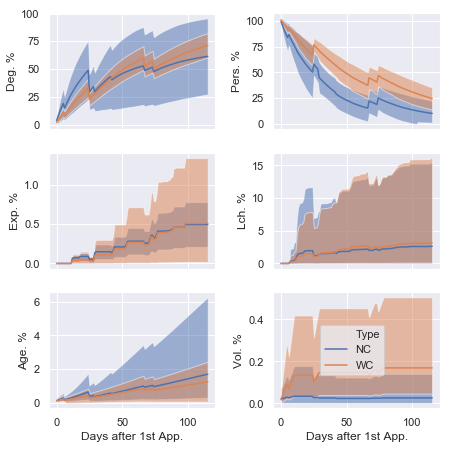

In [78]:
# sns.set(rc={'figure.figsize':(11.7, 8.27)})
# ES&T max width, 1 column = 3.25in, 2-col = 7in 
sns.set_context("paper")
sns.set(rc={'figure.figsize':(7., 7.27)}) # Width, height, inches

fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

# Degradation
# sns.lineplot(x="Jdays", y="value", data=deg_all.loc[deg_all['variable']=="DEG_95%"], hue="Type", ax=ax1, legend=False)
g1 = sns.lineplot(x="Jdays", y="value", data=deg_all.loc[deg_all['variable']=="DEG_50%"], hue="Type", ci=None, ax=axes[0,0], legend=False)
# sns.lineplot(x="Jdays", y="value", data=deg_all.loc[deg_all['variable']=="DEG_05%"], hue="Type", ci=None, ax=ax1, legend=False)

ax1.fill_between(time, deg_max_nc, deg_min_nc, alpha=0.5)
ax1.fill_between(time, deg_max_wc, deg_min_wc, alpha=0.5)
ax1.set_ylabel("Deg. %")

# Persistence
# sns.lineplot(x="Jdays", y="value", data=per_all.loc[per_all['variable']=="PER_95%"], hue="Type", ci=None, ax=ax2, legend=False)
g2 = sns.lineplot(x="Jdays", y="value", data=per_all.loc[per_all['variable']=="PER_50%"], hue="Type", ci=None, ax=ax2, legend=False)
# sns.lineplot(x="Jdays", y="value", data=per_all.loc[per_all['variable']=="PER_05%"], hue="Type", ci=None, ax=ax2, legend=False)
ax2.fill_between(time, per_max_nc, per_min_nc, alpha=0.5)
ax2.fill_between(time, per_max_wc, per_min_wc, alpha=0.5)
ax2.set_ylabel("Pers. %")

# Export
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_95%"], hue="Type", ci=None, ax=ax3, legend=False)
g3 = sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_50%"], hue="Type", ci=None, ax=ax3, legend=False)
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_05%"], hue="Type", ci=None, ax=ax3, legend=False)

ax3.fill_between(time, exp_max_nc, exp_min_nc, alpha=0.5)
ax3.fill_between(time, exp_max_wc, exp_min_wc, alpha=0.5)
ax3.set_ylabel("Exp. %")
ax3.set_xlabel("Days after 1st App.")

# Leaching
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_95%"], hue="Type", ci=None, ax=ax3, legend=False)
g4 = sns.lineplot(x="Jdays", y="value", data=lch_all.loc[lch_all['variable']=="LCH_50%"], hue="Type", ci=None, ax=ax4, legend=False)
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_05%"], hue="Type", ci=None, ax=ax3, legend=False)

ax4.fill_between(time, lch_max_nc, lch_min_nc, alpha=0.5)
ax4.fill_between(time, lch_max_wc, lch_min_wc, alpha=0.5)
ax4.set_ylabel("Lch. %")
ax4.set_xlabel("Days after 1st App.")

# Ageing
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_95%"], hue="Type", ci=None, ax=ax3, legend=False)
g5 = sns.lineplot(x="Jdays", y="value", data=age_all.loc[age_all['variable']=="AGE_50%"], hue="Type", ci=None, ax=ax5, legend=False)
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_05%"], hue="Type", ci=None, ax=ax3, legend=False)

ax5.fill_between(time, age_max_nc, age_min_nc, alpha=0.5)
ax5.fill_between(time, age_max_wc, age_min_wc, alpha=0.5)
ax5.set_ylabel("Age. %")
ax5.set_xlabel("Days after 1st App.")

# Volat
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_95%"], hue="Type", ci=None, ax=ax3, legend=False)
g6 = sns.lineplot(x="Jdays", y="value", data=vol_all.loc[vol_all['variable']=="VOL_50%"], hue="Type", ci=None, ax=ax6)
# sns.lineplot(x="Jdays", y="value", data=exp_all.loc[exp_all['variable']=="EXP_05%"], hue="Type", ci=None, ax=ax3, legend=False)

ax6.fill_between(time, vol_max_nc, vol_min_nc, alpha=0.5)
ax6.fill_between(time, vol_max_wc, vol_min_wc, alpha=0.5)
ax6.set_ylabel("Vol. %")
ax6.set_xlabel("Days after 1st App.")

g6.legend(loc='center right', bbox_to_anchor=(0.7, 0.5), ncol=1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.35, hspace=None)

plt.show()

# fig.savefig("Fig4_Metrics.pdf")

In [28]:
# Resize figure box to put it out of the fig
box = g1.get_position() # position of figure
g1.set_position([box.x0, box.y0, box.width * 1., box.height])

box = g2.get_position() # position of figure
g2.set_position([box.x0, box.y0, box.width * 1., box.height])

box = g3.get_position() # position of figure
g3.set_position([box.x0, box.y0, box.width * 1., box.height])




# fig.savefig("Metrics.pdf")

### Persistence

In [50]:
print("Mean")
print(per_ave_nc[-1])
print(per_ave_wc[-1])

print(per_max_nc[-1], per_min_nc[-1])
print(per_max_wc[-1], per_min_wc[-1])

Mean
6.262058580437007
18.349095793540467
(12.922861325128011, 1.6193217936630417)
(26.11080598133899, 10.587385605741947)


### Leaching

In [47]:
print("Mean")
print(lch_ave_nc[-1])
print(lch_ave_wc[-1])

print("Max, Min")
print(lch_max_nc[-1], lch_min_nc[-1])
print(lch_max_wc[-1], lch_min_wc[-1])

print("Upper CI")
upper_nc = lch_max_nc[-1]- lch_ave_nc[-1]
print(upper_nc)
upper_wc = lch_max_wc[-1]- lch_ave_wc[-1]
print(upper_wc)

Mean
2.4532885312785613
0.9768017097387804
Max, Min
(16.551381205341826, 0.017219518314808363)
(3.846831980653957, 0.028981671425842057)
Upper CI
14.098092674063265
2.8700302709151764


### Degradation

In [35]:
print("Mean")
print(deg_ave_nc[-1]) 
print(deg_ave_wc[-1])

print("Max, Min")
print(deg_max_nc[-1], deg_min_nc[-1])
print(deg_max_wc[-1], deg_min_wc[-1])

Mean
80.58093599727225
80.38383668562281
Max, Min
(115.87061061451784, 45.291261380026654)
(87.63860942772175, 73.12906394352389)


In [36]:
time[-1]

115

### Export

In [42]:
print("Mean")
print(exp_ave_nc[-1])
print(exp_ave_wc[-1])
factor = (exp_ave_wc[-1]/exp_ave_nc[-1])
print(factor)

print("Max, Min")
print(exp_max_nc[-1], exp_min_nc[-1])
print(exp_max_wc[-1], exp_min_wc[-1])

Mean
0.47377158412733256
0.6668596561281025
1.4075551984748729
Max, Min
(0.746589830893068, 0.2009533373615971)
(0.9746055895112712, 0.35911372274493397)


In [51]:
24*5

120

In [98]:
.5*.6

0.3